In [1]:
import os
import yaml
import pandas as pd
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

In [2]:
def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('../..', 'config'), 'db_default_profile.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host=config["host"],
            username=config["user"],
            database=config["db"],
            password=config["pass"],
            port=config["port"],
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)

conn = connect()

In [4]:
import RecallAdjuster as ra

In [5]:
from importlib import reload
reload(ra)

<module 'RecallAdjuster' from '/mnt/data/users/kit/joco/johnson-county-ddj/data_exploration/kit_bias_testbed/RecallAdjuster.py'>

In [ ]:
# Add a 2-way race column to the entity_demos table for these analyses...

# ALTER TABLE kit_bias_class_test.entity_demos ADD COLUMN race_2way VARCHAR(64);
# UPDATE kit_bias_class_test.entity_demos
#     SET race_2way = CASE WHEN race_3way='W' THEN 'White' ELSE 'NonWhite' END;

# ALTER TABLE kit_bias_class_test.currmatch_entity_demos ADD COLUMN race_2way VARCHAR(64);
# UPDATE kit_bias_class_test.currmatch_entity_demos
#     SET race_2way = CASE WHEN race_3way='W' THEN 'White' ELSE 'NonWhite' END;

In [7]:
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='kit',
        schema='kit_bias_class_figs',
        experiment_hashes='09b3bcab5a6e1eb1c712571f6a5abb75',
        date_pairs=[('2016-04-01', '2017-04-01'), ('2017-04-01', '2018-04-01')],
        list_sizes=[500, 750],
        #entity_demos='joco',
        entity_demos='kit_bias_class_test.entity_demos',
        demo_col='race_2way'
)

# myRA.plot(plot_type='shift', )

Date Pair: ('2017-04-01', '2018-04-01')
List Size: 500
Metric: precision@500_abs


{'White_to_NonWhite': <matplotlib.axes._subplots.AxesSubplot at 0x7f60e6dac9b0>,
 'NonWhite_to_White': <matplotlib.axes._subplots.AxesSubplot at 0x7f60e6d6aac8>}

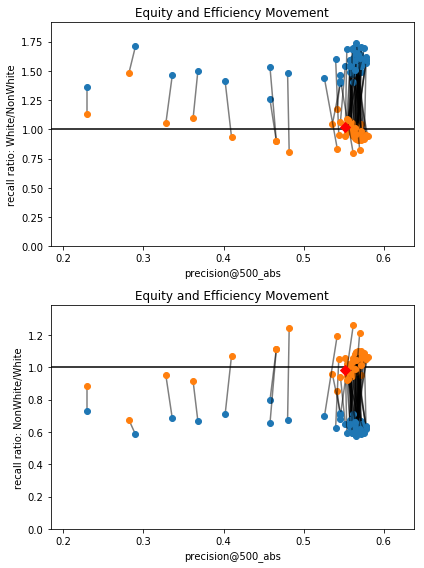

In [10]:
myRA.plot(recall_ratio='all_demos', list_size=500)

Date Pair: ('2017-04-01', '2018-04-01')
List Size: 500
Metric: precision@500_abs


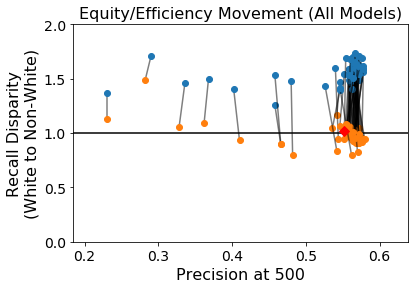

In [29]:
axd = myRA.plot(recall_ratio='White_to_NonWhite', list_size=500)

axd['White_to_NonWhite'].set_ylim((0.0,2.00))
axd['White_to_NonWhite'].set_xlabel('Precision at 500', fontsize=16)
axd['White_to_NonWhite'].set_ylabel('Recall Disparity\n(White to Non-White)', fontsize=16)
axd['White_to_NonWhite'].set_title('Equity/Efficiency Movement (All Models)', fontsize=16)
axd['White_to_NonWhite'].tick_params(axis='x', labelsize=14)
axd['White_to_NonWhite'].tick_params(axis='y', labelsize=14)

Date Pair: ('2017-04-01', '2018-04-01')
List Size: 500
Metric: precision@500_abs


[]

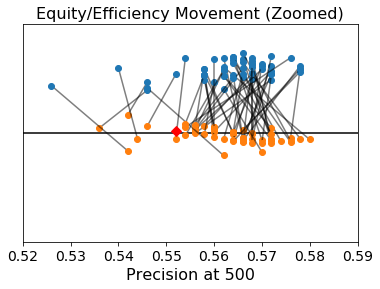

In [32]:
axd = myRA.plot(recall_ratio='White_to_NonWhite', list_size=500)

axd['White_to_NonWhite'].set_xlim((0.52,0.59))
axd['White_to_NonWhite'].set_ylim((0.0,2.00))
axd['White_to_NonWhite'].set_xlabel('Precision at 500', fontsize=16)
axd['White_to_NonWhite'].set_ylabel('')
axd['White_to_NonWhite'].set_title('Equity/Efficiency Movement (Zoomed)', fontsize=16)
axd['White_to_NonWhite'].tick_params(axis='x', labelsize=14)
axd['White_to_NonWhite'].yaxis.set_ticks([])

In [37]:
import dateparser

mvmt_df = myRA.adjustment_results.loc[
            (myRA.adjustment_results['list_size'] == 500)
            &
            (myRA.adjustment_results['metric'] == 'precision@')
            &
            (myRA.adjustment_results['train_end_time'] == dateparser.parse('2018-04-01'))
            &
            (myRA.adjustment_results['past_train_end_time'] == dateparser.parse('2017-04-01'))
        ,
        ['base_value', 'base_%s' % 'recall_white_to_nonwhite', 'adj_value', 'adj_%s' % 'recall_white_to_nonwhite']
        ]

In [40]:
mvmt_df['delta_prec'] = mvmt_df['adj_value'] - mvmt_df['base_value']

mvmt_df.loc[mvmt_df['base_value'] > 0.5, ].head()

,base_value,base_recall_white_to_nonwhite,adj_value,adj_recall_white_to_nonwhite,delta_prec
128,0.578,1.617248,0.566,0.928672,-0.012
130,0.562,1.693056,0.566,0.956065,0.004
132,0.562,1.607505,0.580,0.941167,0.018
134,0.564,1.701479,0.570,0.939997,0.006
136,0.564,1.672154,0.576,0.916882,0.012


In [43]:
mvmt_df.loc[mvmt_df['base_value'] > 0.5, ]['delta_prec'].describe()

count    56.000000
mean     -0.000643
std       0.008673
min      -0.022000
25%      -0.006000
50%      -0.002000
75%       0.006000
max       0.018000
Name: delta_prec, dtype: float64

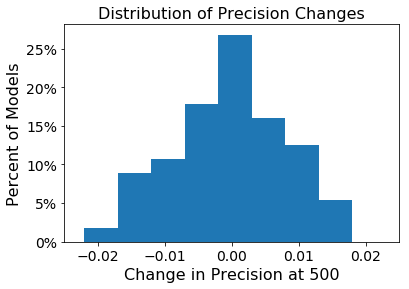

In [81]:
from matplotlib.ticker import PercentFormatter
import numpy as np

ax = mvmt_df.loc[mvmt_df['base_value'] > 0.5, ]['delta_prec'].plot.hist(bins=8, xlim=(-0.025,0.025), 
                                                                        weights=np.ones(56) / 56)

ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_title('Distribution of Precision Changes', fontsize=16)
ax.set_xlabel('Change in Precision at 500', fontsize=16)
ax.set_ylabel('Percent of Models', fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

In [82]:
# pickle a few things for future use / figure creation

import pickle

myRA.engine.close()
myRA.engine = None

pickle.dump(myRA, open('joco_figs_20200527_movement.pkl', 'wb'))

In [315]:
# load the previous results data


with open('joco_recall_adj_data.pkl', 'rb') as f:
    load_dict = pickle.load(f)

ts_df4  = load_dict['time_series_plot_df']
ts_df   = load_dict['list_size_plot_df']
myRA2   = load_dict['recall_adjuster_obj']
# conn = connect()
# myRA.engine = conn

del(load_dict)

In [316]:
ts_no_decoup = ts_df4.loc[ts_df4['strategy'] != 'Composite w/ Decoupled - Adjusted', ].copy()
ls_no_decoup = ts_df.loc[ts_df['strategy'] != 'Composite w/ Decoupled - Adjusted', ].copy()

In [112]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([4,8,12])  # every month
months_fmt = mdates.DateFormatter('%b %y')

# Selection Strategy

In [574]:
ts_no_decoup['strategy'] = ts_no_decoup['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

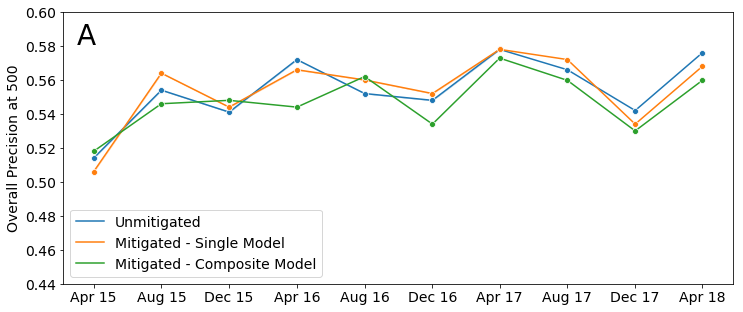

In [576]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_no_decoup.loc[ts_no_decoup['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.44,0.60))
ax.set_ylabel('Overall Precision at 500', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'A', fontsize=28, transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=1, fontsize=14)


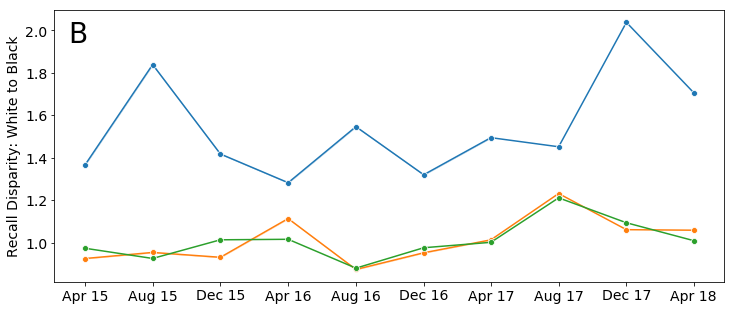

In [577]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_no_decoup.loc[ts_no_decoup['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity: White to Black', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'B', fontsize=28, transform=ax.transAxes)

ax.get_legend().remove()

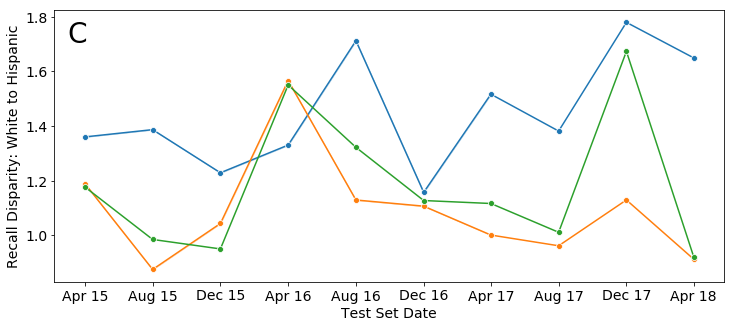

In [578]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_no_decoup.loc[ts_no_decoup['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity: White to Hispanic', fontsize=14)
ax.set_xlabel('Test Set Date', fontsize=14)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'C', fontsize=28, transform=ax.transAxes)

ax.get_legend().remove()

# List Size

In [579]:
ls_no_decoup['strategy'] = ls_no_decoup['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

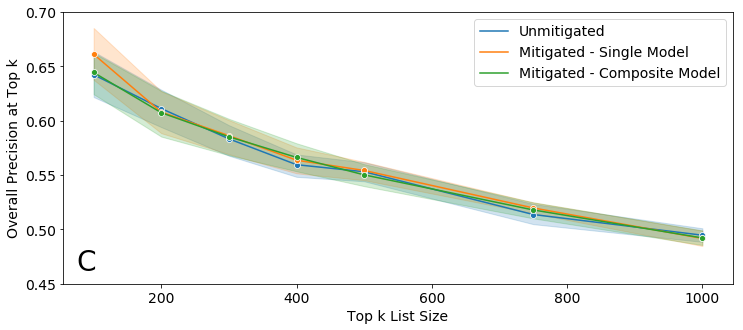

In [581]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ls_no_decoup.loc[ls_no_decoup['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='list_size', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.45,0.70))
ax.set_ylabel('Overall Precision at Top k', fontsize=14)
ax.set_xlabel('Top k List Size', fontsize=14)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.05, 'C', fontsize=28, transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, fontsize=14)

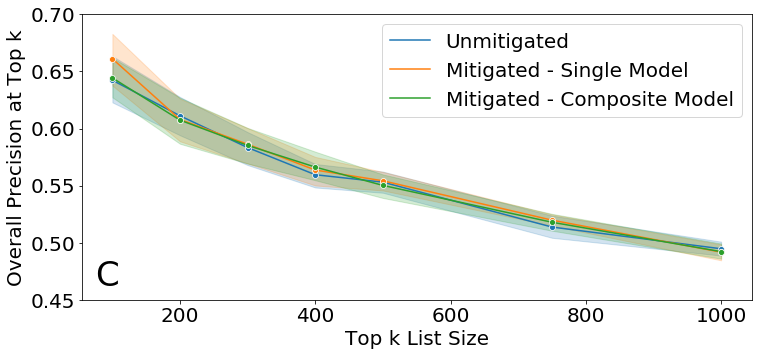

In [583]:
fig, ax = plt.subplots(figsize=(12,5.25))
sns.lineplot(data=ls_no_decoup.loc[ls_no_decoup['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='list_size', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.45,0.70))
ax.set_ylabel('Overall Precision at Top k', fontsize=20)
ax.set_xlabel('Top k List Size', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ax.text(0.02, 0.05, 'C', fontsize=34, transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, fontsize=20)

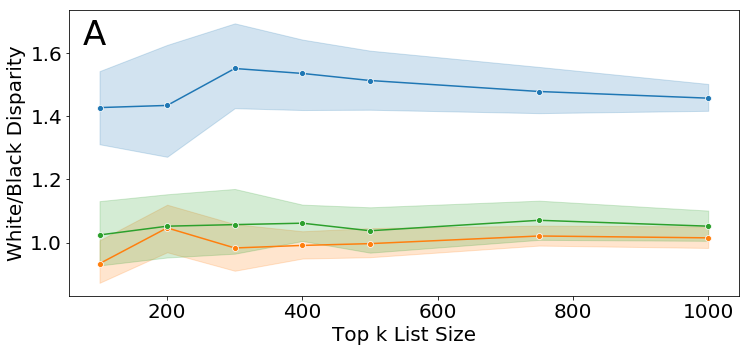

In [584]:
fig, ax = plt.subplots(figsize=(12,5.25))
sns.lineplot(data=ls_no_decoup.loc[ls_no_decoup['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='list_size', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('White/Black Disparity', fontsize=20)
ax.set_xlabel('Top k List Size', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ax.text(0.02, 0.88, 'A', fontsize=34, transform=ax.transAxes)

ax.get_legend().remove()

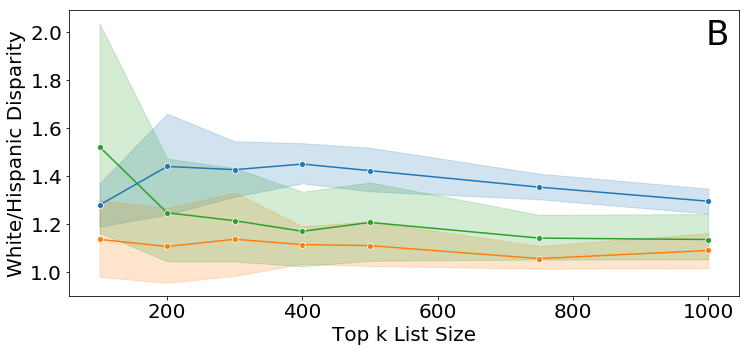

In [587]:
fig, ax = plt.subplots(figsize=(12,5.25))
sns.lineplot(data=ls_no_decoup.loc[ls_no_decoup['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='list_size', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('White/Hispanic Disparity', fontsize=20)
ax.set_xlabel('Top k List Size', fontsize=20)

ax.yaxis.set_ticks([1.0, 1.2, 1.4, 1.6, 1.8, 2.0])

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ax.text(0.95, 0.88, 'B', fontsize=34, transform=ax.transAxes)

ax.get_legend().remove()

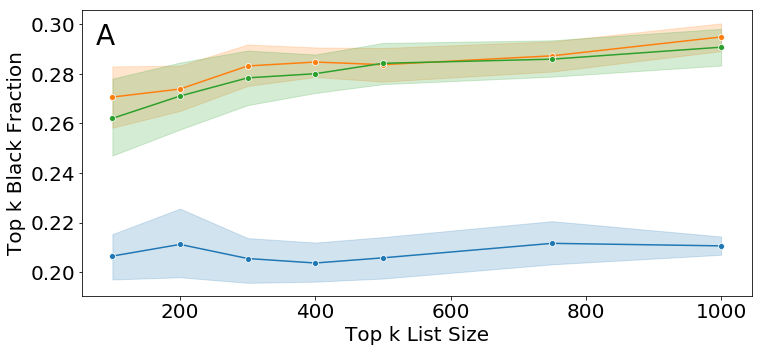

In [588]:
fig, ax = plt.subplots(figsize=(12,5.25))
sns.lineplot(data=ls_no_decoup.loc[ls_no_decoup['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='list_size', y='frac_b', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Top k Black Fraction', fontsize=20)
ax.set_xlabel('Top k List Size', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ax.text(0.02, 0.88, 'A', fontsize=28, transform=ax.transAxes)

ax.get_legend().remove()

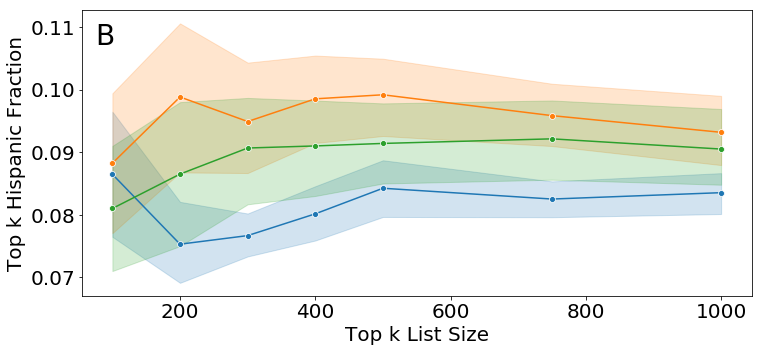

In [589]:
fig, ax = plt.subplots(figsize=(12,5.25))
sns.lineplot(data=ls_no_decoup.loc[ls_no_decoup['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='list_size', y='frac_h', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Top k Hispanic Fraction', fontsize=20)
ax.set_xlabel('Top k List Size', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ax.text(0.02, 0.88, 'B', fontsize=28, transform=ax.transAxes)

ax.get_legend().remove()

# Bootstrap Group Size

In [592]:
# load from scripted experiment...

with open('boostrap_hisp_frac_test_new.pkl', 'rb') as f:
    ts_df3 = pickle.load(f)

In [593]:
ts_df3['strategy'] = ts_df3['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

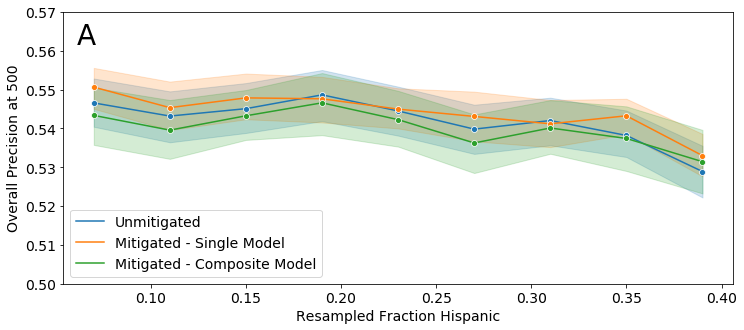

In [602]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[(ts_df3['list_size']==500) & (ts_df3['strategy'] != 'Mitigated - Unadj. Model Seln.'), ], x='bootstrap_frac_h', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.50,0.57))
ax.set_ylabel('Overall Precision at 500', fontsize=14)
ax.set_xlabel('Resampled Fraction Hispanic', fontsize=14)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'A', fontsize=28, transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, loc='lower left', fontsize=14)

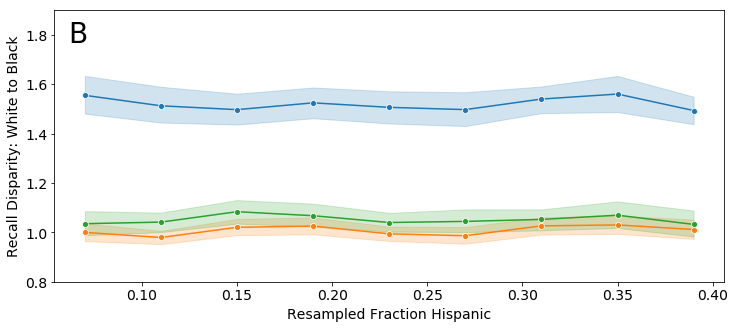

In [605]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[(ts_df3['list_size']==500) & (ts_df3['strategy'] != 'Mitigated - Unadj. Model Seln.'), ], x='bootstrap_frac_h', y='recall_w_to_b', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.8,1.9))
ax.set_ylabel('Recall Disparity: White to Black', fontsize=14)
ax.set_xlabel('Resampled Fraction Hispanic', fontsize=14)

# ax.yaxis.set_ticks([0.8,1.0,1.2,1.4,1.6])

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'B', fontsize=28, transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=2, fontsize=14)

ax.get_legend().remove()


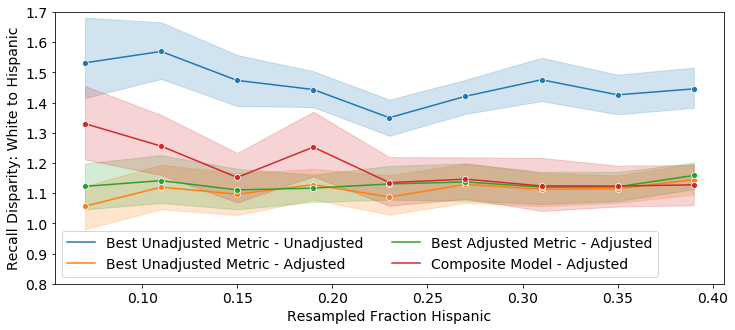

In [161]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[ts_df3['list_size']==500, ], x='bootstrap_frac_h', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.8,1.7))
ax.set_ylabel('Recall Disparity: White to Hispanic', fontsize=14)
ax.set_xlabel('Resampled Fraction Hispanic', fontsize=14)

# ax.yaxis.set_ticks([0.8,1.0,1.2,1.4,1.6])

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=2, fontsize=14)


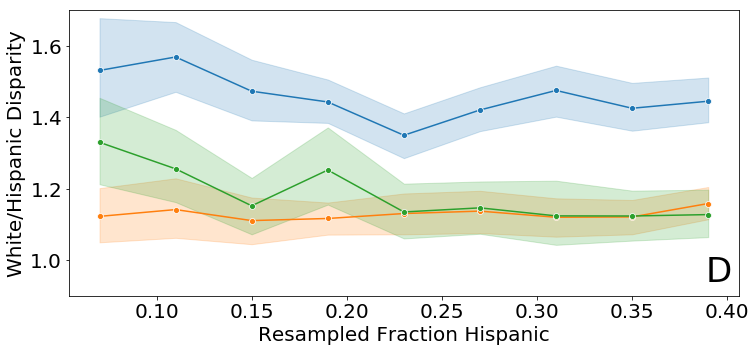

In [608]:
# with open('boostrap_hisp_frac_test_new.pkl', 'rb') as f:
#     bs_df = pickle.load(f)

fig, ax = plt.subplots(figsize=(12,5.25))
sns.lineplot(data=ts_df3.loc[(ts_df3['list_size']==500) & (ts_df3['strategy'] != 'Mitigated - Unadj. Model Seln.'), ], x='bootstrap_frac_h', y='recall_w_to_h', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.9,1.7))
ax.set_ylabel('White/Hispanic Disparity', fontsize=20)
ax.set_xlabel('Resampled Fraction Hispanic', fontsize=20)

# ax.yaxis.set_ticks([0.8,1.0,1.2,1.4,1.6])

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ax.text(0.95, 0.05, 'D', fontsize=34, transform=ax.transAxes)

ax.get_legend().remove()


# 2-Way Results for Comparison with Other Datasets

However, excluding the fully decoupled composit here as well because they were trained on the 3-way race. Can explore adding back if seems necessary, but given how similar the results are to the other composite (at least for JoCo), doesn't seem like a ton of value there...

In [165]:
import datetime
from dateutil.relativedelta import relativedelta
base = datetime.datetime.strptime('2018-04-01', '%Y-%m-%d')
date_pairs = []
for x in range(9,-1,-1):
    date_pairs.append(
        (
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d')
        )
    )
    date_pairs.append(
        (
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=4*x)).strftime('%Y-%m-%d')
        )
    )

In [167]:
conn.dispose()
conn = connect()

myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='kit',
        schema='kit_bias_class_figs',
        experiment_hashes='09b3bcab5a6e1eb1c712571f6a5abb75',
        date_pairs=date_pairs,
        list_sizes=[500],
        #entity_demos='joco',
        entity_demos='kit_bias_class_test.entity_demos',
        demo_col='race_2way'
)

In [174]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_class_figs.model_adjustment_results_race_2way
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_white_to_nonwhite AS recall_white_to_nonwhite,
       r.base_frac_white AS frac_white,
       r.base_frac_nonwhite AS frac_nonwhite
FROM kit_bias_class_figs.model_adjustment_results_race_2way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_white_to_nonwhite AS recall_white_to_nonwhite,
       r.adj_frac_white AS frac_white,
       r.adj_frac_nonwhite AS frac_nonwhite
FROM kit_bias_class_figs.model_adjustment_results_race_2way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_white_to_nonwhite AS recall_white_to_nonwhite,
       r.adj_frac_white AS frac_white,
       r.adj_frac_nonwhite AS frac_nonwhite
FROM kit_bias_class_figs.model_adjustment_results_race_2way r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_white_to_nonwhite,
      frac_white,
      frac_nonwhite
FROM kit_bias_class_figs.composite_results_race_2way
WHERE train_end_time > past_train_end_time
;
"""

In [175]:
ts_df3 = pd.read_sql(sql, conn)

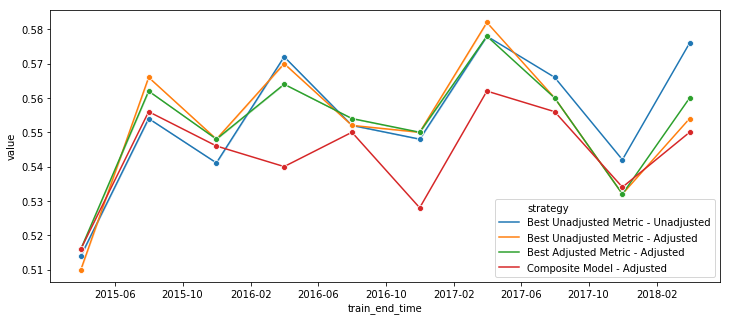

In [176]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

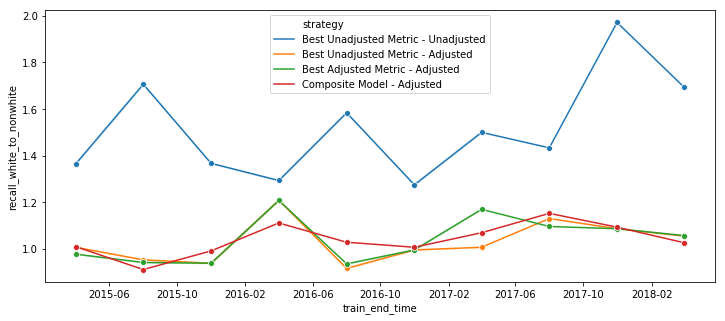

In [177]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_white_to_nonwhite', hue='strategy', marker="o", ax=ax)

In [180]:
ts_df3.groupby(['strategy'])[['value', 'recall_white_to_nonwhite']].describe()

value                                     \
                                    count      mean       std    min     25%   
strategy                                                                       
Best Adjusted Metric - Adjusted      17.0  0.552706  0.017677  0.516  0.5480   
Best Unadjusted Metric - Adjusted    17.0  0.553059  0.020702  0.510  0.5480   
Best Unadjusted Metric - Unadjusted  17.0  0.553068  0.019639  0.514  0.5420   
Composite Model - Adjusted           10.0  0.543800  0.014312  0.516  0.5355   

                                                           \
                                       50%     75%    max   
strategy                                                    
Best Adjusted Metric - Adjusted      0.554  0.5620  0.578   
Best Unadjusted Metric - Adjusted    0.552  0.5660  0.582   
Best Unadjusted Metric - Unadjusted  0.552  0.5720  0.578   
Composite Model - Adjusted           0.548  0.5545  0.562   

                                    recall_white_to_nonwhite            \
                                                       count      mean   
strategy                                                                 
Best Adjusted Metric - Adjusted                         17.0  1.033654   
Best Unadjusted Metric - Adjusted                       17.0  1.018958   
Best Unadjusted Metric - Unadjusted                     17.0  1.486855   
Composite Model - Adjusted                              10.0  1.039987   

                                                                             \
                                          std       min       25%       50%   
strategy                                                                      
Best Adjusted Metric - Adjusted      0.102557  0.935874  0.941833  0.995483   
Best Unadjusted Metric - Adjusted    0.091695  0.916348  0.953046  1.006931   
Best Unadjusted Metric - Unadjusted  0.196716  1.275024  1.363858  1.433412   
Composite Model - Adjusted           0.068822  0.911344  1.007670  1.027376   

                                                         
                                          75%       max  
strategy                                                 
Best Adjusted Metric - Adjusted      1.095994  1.207792  
Best Unadjusted Metric - Adjusted    1.054455  1.208588  
Best Unadjusted Metric - Unadjusted  1.584129  1.971349  
Composite Model - Adjusted           1.087138  1.152421

(0.4, 0.6)

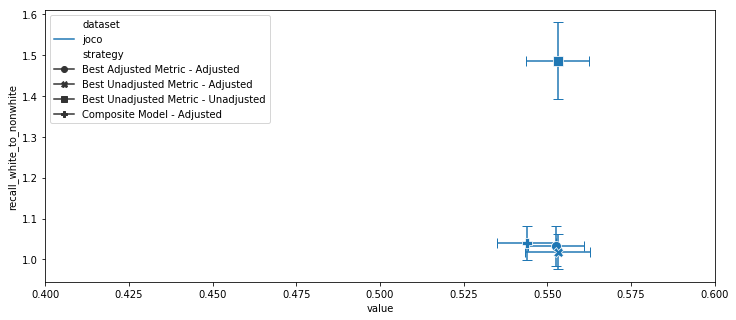

In [265]:
ts_df3['dataset'] = 'joco'

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.groupby(['dataset', 'strategy'])[['value', 'recall_white_to_nonwhite']].mean().reset_index(), 
              x='value', y='recall_white_to_nonwhite', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


x_coords = list(ts_df3.groupby(['dataset', 'strategy'])[['value', 'recall_white_to_nonwhite']].mean().reset_index()['value'].values)
y_coords = list(ts_df3.groupby(['dataset', 'strategy'])[['value', 'recall_white_to_nonwhite']].mean().reset_index()['recall_white_to_nonwhite'].values)

prec_errors = 1.96*ts_df3.groupby(['dataset', 'strategy'])['value'].sem().values
disp_errors = 1.96*ts_df3.groupby(['dataset', 'strategy'])['recall_white_to_nonwhite'].sem().values
colors = sns.color_palette().as_hex()[0]
ax.errorbar(x_coords, y_coords, 
            xerr=prec_errors, 
            yerr=disp_errors,
    ecolor=colors, 
    fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.60))

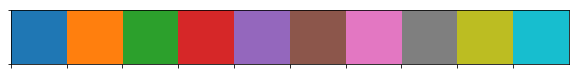

In [250]:
sns.palplot(sns.color_palette())

In [256]:
sns.color_palette().as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [267]:
ts_df3.head()

,strategy,train_end_time,past_train_end_time,list_size,metric,parameter,value,max_recall_ratio,recall_white_to_nonwhite,frac_white,frac_nonwhite,dataset
0,Best Unadjusted Metric - Unadjusted,2015-04-01,2014-04-01,500,precision@,500_abs,0.514000,1.363858,1.363858,0.704,0.296,joco
1,Best Unadjusted Metric - Unadjusted,2015-04-01,2014-04-01,500,precision@,500_abs,0.514000,1.363858,1.363858,0.704,0.296,joco
2,Best Unadjusted Metric - Unadjusted,2015-08-01,2014-08-01,500,precision@,500_abs,0.554000,1.706214,1.706214,0.748,0.252,joco
3,Best Unadjusted Metric - Unadjusted,2015-08-01,2014-08-01,500,precision@,500_abs,0.554000,1.706214,1.706214,0.748,0.252,joco
4,Best Unadjusted Metric - Unadjusted,2015-12-01,2014-12-01,500,precision@,500_abs,0.541082,1.367013,1.367013,0.686,0.312,joco


In [268]:
exp_df = ts_df3.rename(
    {'recall_white_to_nonwhite': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')


In [277]:
sj_exp_df = pd.read_csv('/mnt/data/users/kit/sj/san_jose_housing/triage4/sj_figs_20200531_exp_df.csv')


In [568]:
sj_exp_df['train_end_time'] = pd.to_datetime(sj_exp_df['train_end_time'])

In [563]:
sj_exp_df['strategy'] = sj_exp_df['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

In [569]:
months4 = mdates.MonthLocator([3,6,9,12])  # every month
months_fmt4 = mdates.DateFormatter('%b %y')

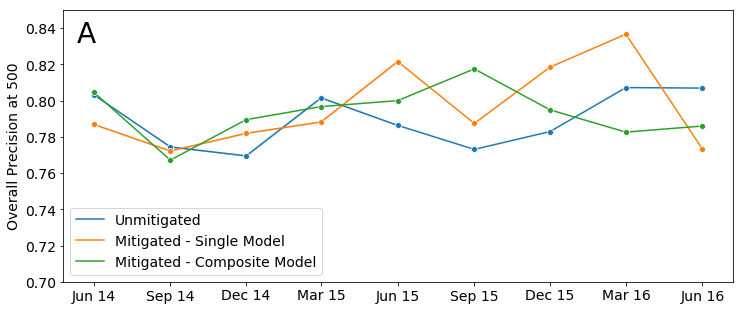

In [570]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=sj_exp_df.loc[sj_exp_df['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.70,0.85))
ax.set_ylabel('Overall Precision at 500', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months4)
ax.xaxis.set_major_formatter(months_fmt4)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'A', fontsize=28, transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, loc='lower left', ncol=1, fontsize=14)

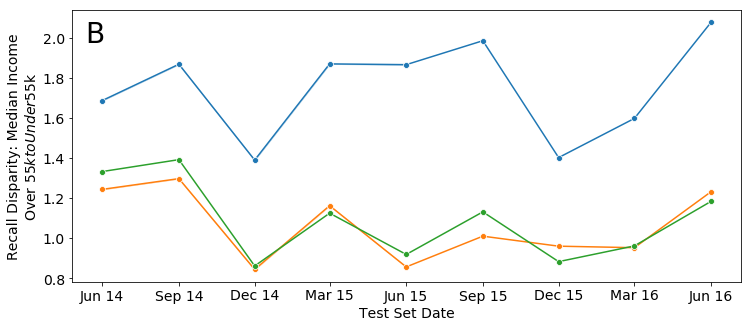

In [572]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=sj_exp_df.loc[sj_exp_df['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='recall_disp', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity: Median Income\nOver $55k to Under $55k', fontsize=14)
ax.set_xlabel('Test Set Date', fontsize=14)

ax.xaxis.set_major_locator(months4)
ax.xaxis.set_major_formatter(months_fmt4)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'B', fontsize=28, transform=ax.transAxes)

ax.get_legend().remove()

In [334]:
comp_df = pd.concat([exp_df, sj_exp_df])

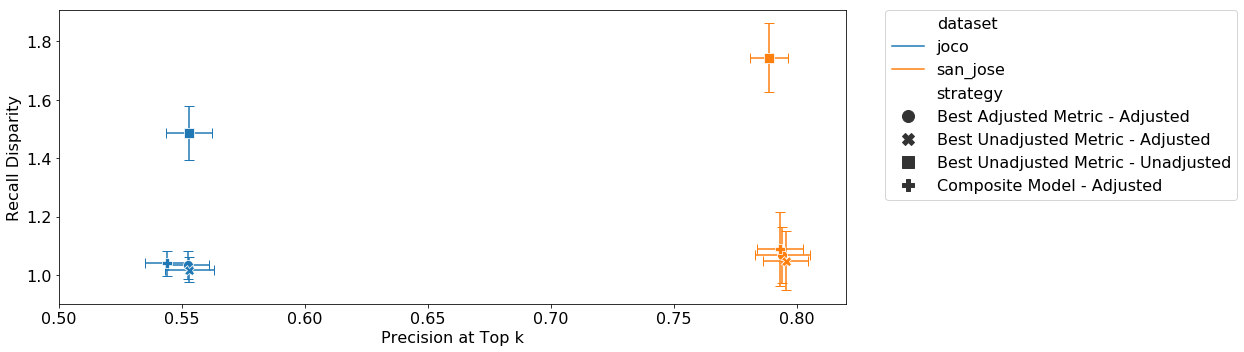

In [310]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.50,0.82))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)

fig.tight_layout()

In [407]:
dc_df = pd.read_csv('donors_all_mgs_20200612.csv')

# dc_df = pd.read_csv('/mnt/data/experiment_data/peep-chili/Donors_Choose_Mul_Dates.csv', sep='\t', index_col=0)

# with open('/mnt/data/experiment_data/peep-chili/Donors_Choose_Mul_Dates.pkl', 'rb') as f:
#     dc_df = pickle.load(f)

In [408]:
# uncomment if using Donors_Choose_Mul_Dates.csv

# dc_df = dc_df.rename(
#     {'recall_not_to_highest': 'recall_disp', 
#      'frac_not_highest': 'frac_grp1', 
#      'frac_highest': 'frac_grp2'
#     }, axis='columns')

dc_df['dataset'] = 'donors_choose'

dc_df = dc_df[sj_exp_df.columns]

# dc_df = dc_df.loc[(dc_df['train_end_time'] >= '2011-07-01') & (dc_df['list_size'] == 1000),]

dc_df['train_end_time'] = pd.to_datetime(dc_df['train_end_time'])

In [409]:
comp_df = pd.concat([exp_df, sj_exp_df, dc_df])

comp_df['dataset'] = comp_df['dataset'].map({
    'donors_choose': 'Education Crowdfunding', 
    'joco': 'Inmate Mental Health', 
    'san_jose': 'Housing Safety'})

comp_df = comp_df.sort_values(['dataset'])

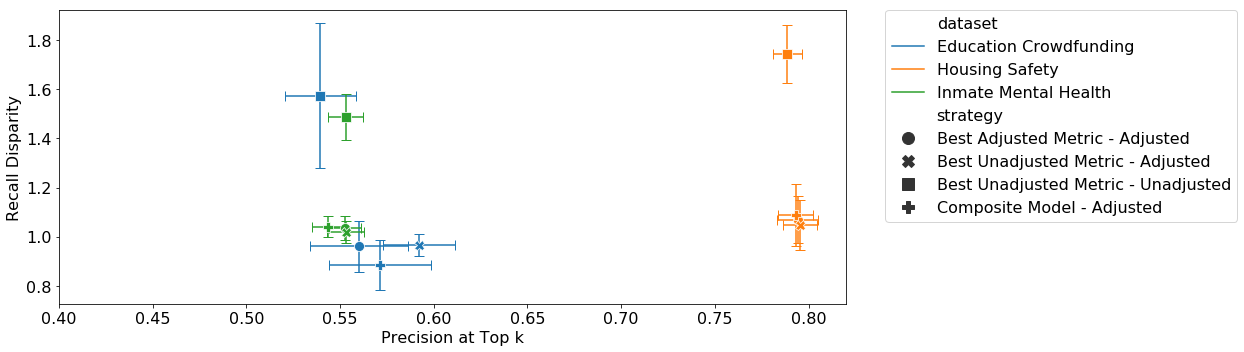

In [410]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.82))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)

fig.tight_layout()

In [388]:
dc_df = pd.read_csv('/mnt/data/experiment_data/peep-chili/Donors_Choose_Mul_Dates.csv', sep='\t', index_col=0)
dc_df = dc_df.loc[(dc_df['train_end_time'] >= '2011-07-01') & (dc_df['list_size'] == 1000),]
dc_df['train_end_time'] = pd.to_datetime(dc_df['train_end_time'])

In [543]:
dc_df['strategy'] = dc_df['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

In [548]:
months3 = mdates.MonthLocator([1,3,5,7,9,11])  # every month
months_fmt3 = mdates.DateFormatter('%b %y')

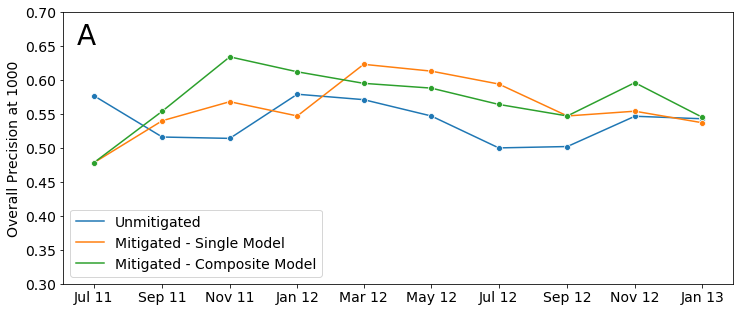

In [559]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=dc_df.loc[dc_df['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.30,0.70))
ax.set_ylabel('Overall Precision at 1000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months3)
ax.xaxis.set_major_formatter(months_fmt3)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'A', fontsize=28, transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=1, fontsize=14)

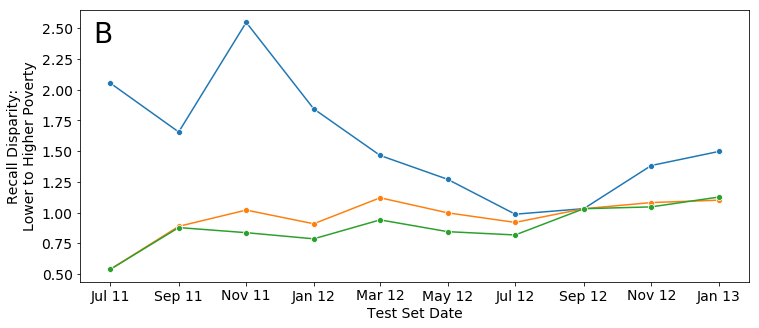

In [558]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=dc_df.loc[dc_df['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='recall_disp', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity:\nLower to Higher Poverty', fontsize=14)
ax.set_xlabel('Test Set Date', fontsize=14)

ax.xaxis.set_major_locator(months3)
ax.xaxis.set_major_formatter(months_fmt3)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'B', fontsize=28, transform=ax.transAxes)

ax.get_legend().remove()

In [402]:
base = datetime.datetime.strptime('2013-01-01', '%Y-%m-%d')
dc_date_pairs = []
for x in range(9,-1,-1):
    dc_date_pairs.append(
        (
        (base - relativedelta(months=2*x) - relativedelta(months=4)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=2*x) - relativedelta(months=4)).strftime('%Y-%m-%d')
        )
    )
    dc_date_pairs.append(
        (
        (base - relativedelta(months=2*x) - relativedelta(months=4)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=2*x)).strftime('%Y-%m-%d')
        )
    )

dc_date_pairs

[('2011-03-01', '2011-03-01'),
 ('2011-03-01', '2011-07-01'),
 ('2011-05-01', '2011-05-01'),
 ('2011-05-01', '2011-09-01'),
 ('2011-07-01', '2011-07-01'),
 ('2011-07-01', '2011-11-01'),
 ('2011-09-01', '2011-09-01'),
 ('2011-09-01', '2012-01-01'),
 ('2011-11-01', '2011-11-01'),
 ('2011-11-01', '2012-03-01'),
 ('2012-01-01', '2012-01-01'),
 ('2012-01-01', '2012-05-01'),
 ('2012-03-01', '2012-03-01'),
 ('2012-03-01', '2012-07-01'),
 ('2012-05-01', '2012-05-01'),
 ('2012-05-01', '2012-09-01'),
 ('2012-07-01', '2012-07-01'),
 ('2012-07-01', '2012-11-01'),
 ('2012-09-01', '2012-09-01'),
 ('2012-09-01', '2013-01-01')]

# El Salvador MinEd

In [474]:
mined_df = pd.read_csv('/mnt/data/experiment_data/peep-chili/ElSal_10K_Overage.csv', sep='\t', index_col=0)

In [475]:
mined_df = mined_df.rename(
    {'recall_1_to_0': 'recall_disp', 
     'frac_1': 'frac_grp1', 
     'frac_0': 'frac_grp2'
    }, axis='columns')

# group fractions are missing?
mined_df['dataset'] = 'el_salvador'
mined_df['frac_grp1'] = np.nan
mined_df['frac_grp2'] = np.nan

mined_df = mined_df[sj_exp_df.columns]

# exclude 2011 datapoint based on selection from 2010 models with no features!
mined_df = mined_df.loc[(mined_df['train_end_time'] > '2011-01-01'),]

mined_df['train_end_time'] = pd.to_datetime(mined_df['train_end_time'])

In [476]:
mined_df.head()

,strategy,train_end_time,past_train_end_time,list_size,metric,parameter,value,max_recall_ratio,recall_disp,frac_grp1,frac_grp2,dataset
0,Best Unadjusted Metric - Unadjusted,2016-01-01,2015-01-01,10000,precision@,10000_abs,0.554070,3.103828,3.103828,NaN,NaN,el_salvador
1,Best Unadjusted Metric - Unadjusted,2014-01-01,2013-01-01,10000,precision@,10000_abs,0.514828,5.484859,5.484859,NaN,NaN,el_salvador
2,Best Unadjusted Metric - Unadjusted,2014-01-01,2013-01-01,10000,precision@,10000_abs,0.514828,5.484859,5.484859,NaN,NaN,el_salvador
5,Best Unadjusted Metric - Unadjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.447868,4.119366,4.119366,NaN,NaN,el_salvador
6,Best Unadjusted Metric - Unadjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.447868,4.119366,4.119366,NaN,NaN,el_salvador


In [536]:
mined_df['strategy'] = mined_df['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

In [537]:
months2 = mdates.MonthLocator([1])  # every month
months_fmt2 = mdates.DateFormatter('%b %y')

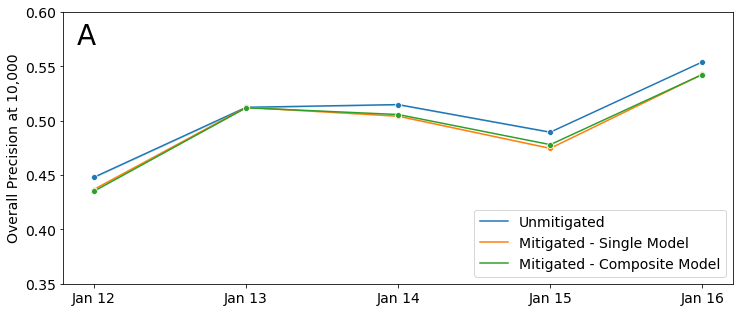

In [561]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=mined_df.loc[mined_df['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.35,0.60))
ax.set_ylabel('Overall Precision at 10,000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months2)
ax.xaxis.set_major_formatter(months_fmt2)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'A', fontsize=28, transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, loc='lower right', ncol=1, fontsize=14)

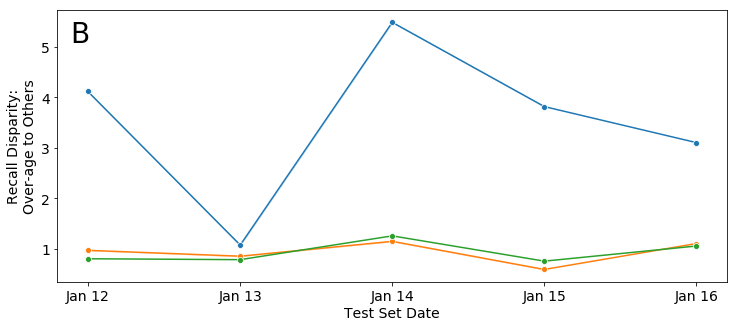

In [562]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=mined_df.loc[mined_df['strategy'] != 'Mitigated - Unadj. Model Seln.', ], x='train_end_time', y='recall_disp', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity:\nOver-age to Others', fontsize=14)
ax.set_xlabel('Test Set Date', fontsize=14)

ax.xaxis.set_major_locator(months2)
ax.xaxis.set_major_formatter(months_fmt2)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.text(0.02, 0.88, 'B', fontsize=28, transform=ax.transAxes)

ax.get_legend().remove()

In [480]:
comp_df = pd.concat([exp_df, sj_exp_df, dc_df, mined_df])

comp_df['dataset'] = comp_df['dataset'].map({
    'donors_choose': 'Education Crowdfunding', 
    'joco': 'Inmate Mental Health', 
    'san_jose': 'Housing Safety',
    'el_salvador': 'Student Outcomes'
})

comp_df = comp_df.sort_values(['dataset'])

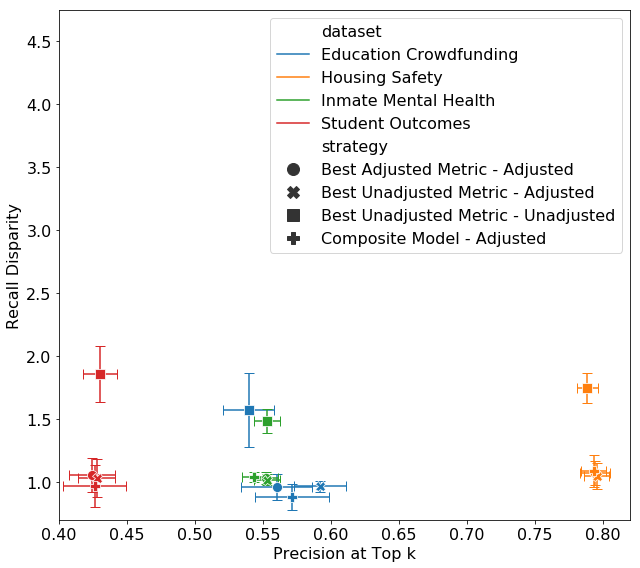

In [473]:
fig, ax = plt.subplots(figsize=(9,8))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.82))
ax.set_ylim((0.7,4.75))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
# ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
ax.legend(hhandles, llabels, fontsize=16, markerscale=2)

# ax.plot((0,1),(1,1),'k-', zorder=0)

fig.tight_layout()


# NOTE: 30k (10%) model:

In [499]:
import matplotlib.path as mpath
from matplotlib.textpath import TextPath

star = mpath.Path.unit_regular_star(10)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

path1 = TextPath((12,12), "U", size=12)
verts = np.concatenate([circle.vertices, path1.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, path1.codes])
cut_text = mpath.Path(verts, codes)


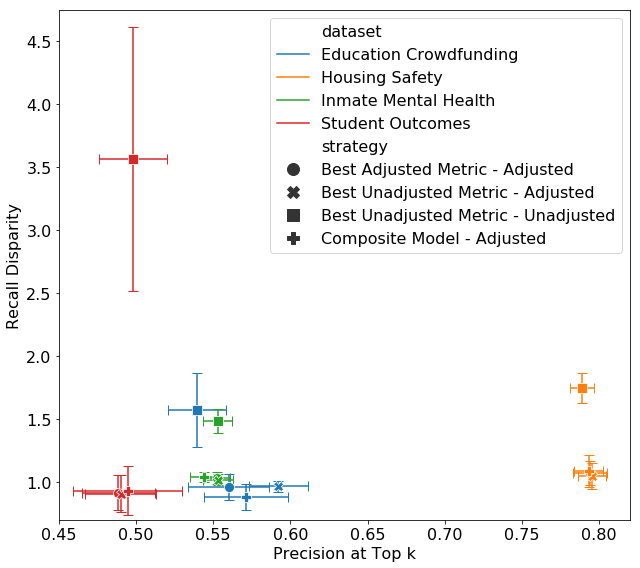

In [524]:
fig, ax = plt.subplots(figsize=(9,8))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              markers=True,
#              markers=['$A1$', '$A2$', '$U$', '$A3$'],
#              markers=['$A1$', '$A2$', cut_star, '$A3$'],
#              markers=['X', 'P', 's', 'o'],
#              color='dodgerblue',
              markersize=10,
#               fillstyle='full',
#               markeredgecolor='black',
#               markeredgewidth=1.0,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.45,0.82))
ax.set_ylim((0.7,4.75))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
# ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
ax.legend(hhandles, llabels, fontsize=16, markerscale=2)

# ax.plot((0,1),(1,1),'k-', zorder=0)

fig.tight_layout()

In [527]:
comp_df['strategy'] = comp_df['strategy'].map({
    'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
    'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
    'Composite Model - Adjusted': 'Mitigated - Composite Model',
    'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.'
})

comp_df['strategy'].unique()

array(['Unmitigated', 'Mitigated - Unadj. Model Seln.',
       'Mitigated - Single Model', 'Mitigated - Composite Model'],
      dtype=object)

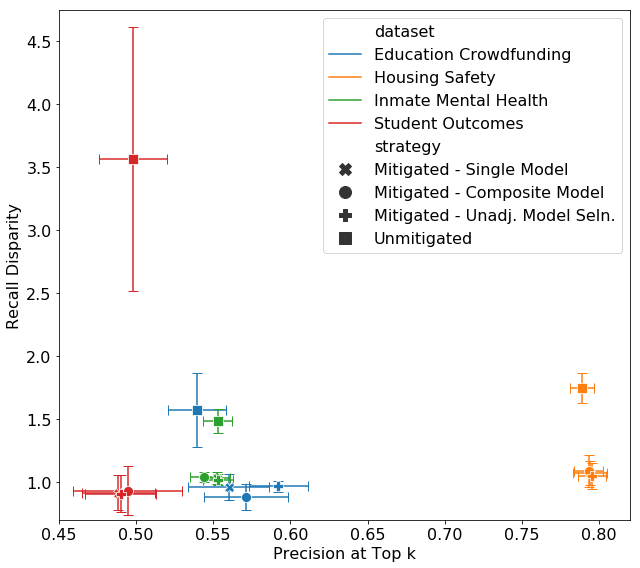

In [532]:
sty_ord = [
    'Mitigated - Single Model', 
    'Mitigated - Composite Model',
    'Mitigated - Unadj. Model Seln.',
    'Unmitigated'
]

fig, ax = plt.subplots(figsize=(9,8))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              style_order=sty_ord,
#              markers=True,
#              markers=['$A1$', '$A2$', '$U$', '$A3$'],
#              markers=['$A1$', '$A2$', cut_star, '$A3$'],
              markers=['X', 'o', 'P', 's'],
#              color='dodgerblue',
              markersize=10,
#               fillstyle='full',
#               markeredgecolor='black',
#               markeredgewidth=1.0,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.45,0.82))
ax.set_ylim((0.7,4.75))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
# ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
ax.legend(hhandles, llabels, fontsize=16, markerscale=2)

# ax.plot((0,1),(1,1),'k-', zorder=0)

fig.tight_layout()

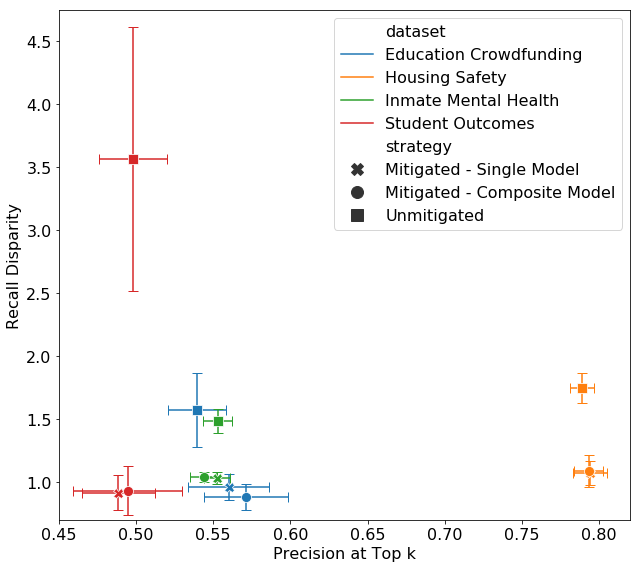

In [535]:
sty_ord = [
    'Mitigated - Single Model', 
    'Mitigated - Composite Model',
    'Unmitigated'
]

fig, ax = plt.subplots(figsize=(9,8))
sns.lineplot(data=comp_df.loc[comp_df['strategy'] != 'Mitigated - Unadj. Model Seln.', ].groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              style_order=sty_ord,
#              markers=True,
#              markers=['$A1$', '$A2$', '$U$', '$A3$'],
#              markers=['$A1$', '$A2$', cut_star, '$A3$'],
              markers=['X', 'o', 's'],
#              color='dodgerblue',
              markersize=10,
#               fillstyle='full',
#               markeredgecolor='black',
#               markeredgewidth=1.0,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[(comp_df['dataset'] == ds) & (comp_df['strategy'] != 'Mitigated - Unadj. Model Seln.'), ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.45,0.82))
ax.set_ylim((0.7,4.75))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
# ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
ax.legend(hhandles, llabels, fontsize=16, markerscale=2)

# ax.plot((0,1),(1,1),'k-', zorder=0)

fig.tight_layout()